## 1. Manual Preprocessing

In [1]:
!pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 12.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import Libraries
import cv2 as cv
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

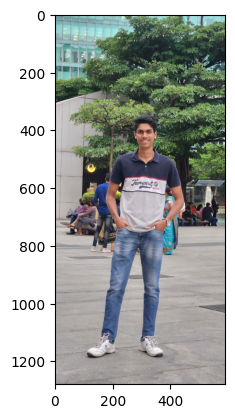

In [4]:
# OpenCV reads the image in BGR channel but what we want to work with is the RGB format so let's start converting it!
img = cv.imread('/content/drive/MyDrive/[02] Work/[02] Projects/[02] Facial Recognition/dataset/adarsh/1.png')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [5]:
# Detect the face using MTCNN
from mtcnn.mtcnn import MTCNN
detector = MTCNN()
results = detector.detect_faces(img)

1/1 [==============================] - 0s 180ms/step


In [6]:
results

[{'box': [279, 378, 63, 81],
  'confidence': 0.9999925494194031,
  'keypoints': {'left_eye': (295, 408),
   'right_eye': (325, 408),
   'nose': (309, 424),
   'mouth_left': (297, 438),
   'mouth_right': (325, 438)}}]

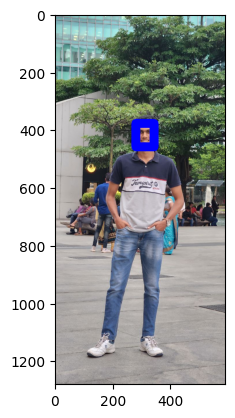

In [8]:
x, y, w, h = results[0]['box']
img = cv.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 8)
plt.imshow(img)

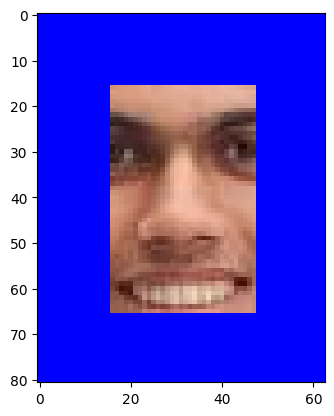

In [9]:
# Facenet only takes in 160*160 as the input!
myFace = img[y: y + h, x: x + w]
plt.imshow(myFace)

## 2. Automatic Preprocessing

In [10]:
class FaceLoading:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160, 160)
        self.X = []
        self.y = []
        self.detector = MTCNN()

    def extract_face(self, filename):
        img = cv.imread(filename)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        x, y, w, h = self.detector.detect_faces(img)[0]['box']
        x, y = abs(x), abs(y)
        face = img[y: y + h, x: x + w]
        face_arr = cv.resize(face, self.target_size)
        return face_arr

    def load_faces(self, dir):
        FACES = []
        for im_name in os.listdir(dir):
            try:
                path = dir + im_name
                single_face = self.extract_face(path)
                FACES.append(single_face)
            except:
                pass
        return FACES

    def load_classes(self):
        for sub_dir in os.listdir(self.directory):
            path = self.directory + '/' + sub_dir + '/'
            FACES = self.load_faces(path)
            labels = [sub_dir] * len(FACES)
            print(f"Loaded Successfully: {len(labels)}")
            self.X.extend(FACES)
            self.y.extend([sub_dir] * len(FACES))
        return np.asarray(self.X), np.asarray(self.y)

    def plot_images(self):
        plt.figure(figsize = (18, 16))
        for num, img in enumerate(self.X):
            ncols = 3
            nrows = len(self.y) // ncols + 1
            plt.subplot(nrows, ncols, num + 1)
            plt.imshow(img)
            plt.axis('off')
        plt.show()

In [11]:
faceloading = FaceLoading("/content/drive/MyDrive/[02] Work/[02] Projects/[02] Facial Recognition/dataset")
X, y = faceloading.load_classes()

1/1 [==============================] - 0s 60ms/step
Loaded Successfully: 3
1/1 [==============================] - 0s 56ms/step
Loaded Successfully: 10
1/1 [==============================] - 0s 36ms/step
Loaded Successfully: 10


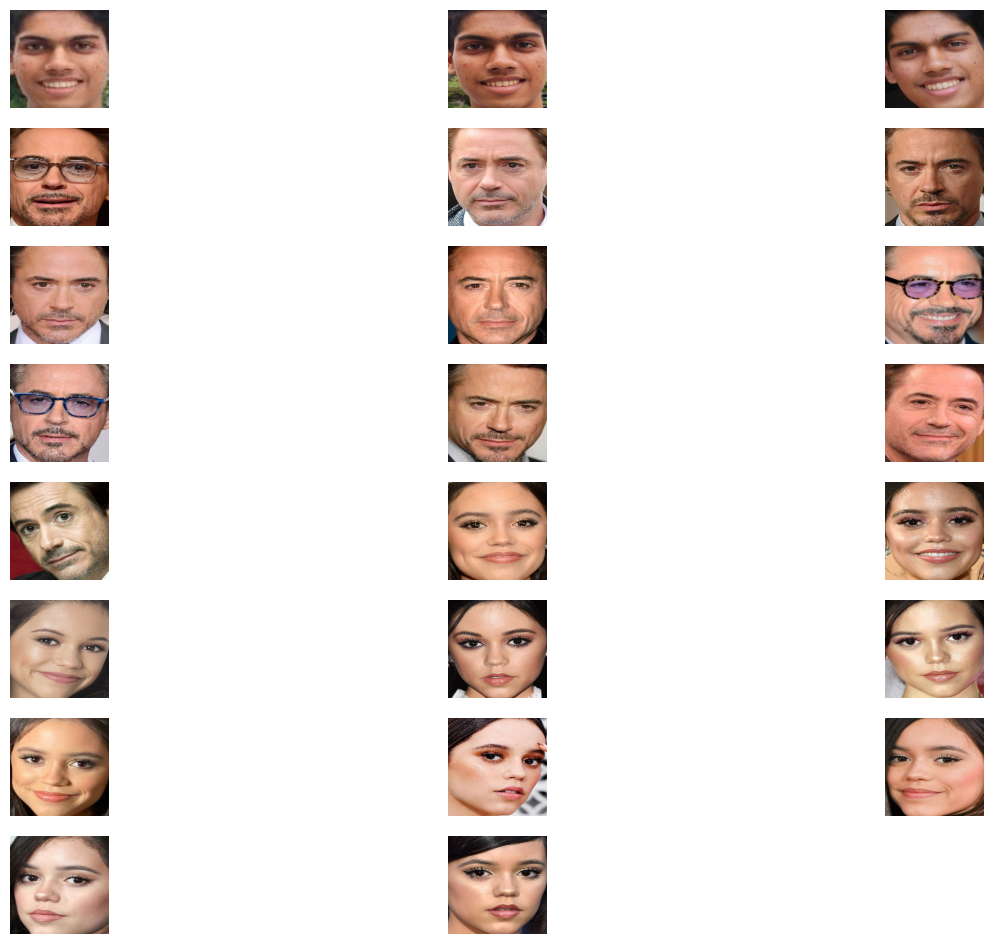

In [12]:
plt.figure(figsize = (16, 12))
for num, img in enumerate(X):
    ncols = 3
    nrows = len(y) // ncols + 1
    plt.subplot(nrows, ncols, num + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

## 3. FaceNet Time!

In [13]:
!pip install keras-facenet

  Preparing metadata (setup.py) ... done
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10369 sha256=22c18fdf91bd5bf69ee6881228798dc7808a84e703754fb20ca30aaed03b68cf
  Stored in directory: /root/.cache/pip/wheels/1d/d8/a9/85cf04ea29321d2afcb82c0caaafdca9195385f9d68cbc7185
Successfully built keras-facenet


In [14]:
from keras_facenet import FaceNet
embedder = FaceNet()

def get_embeddings(face_img):
    # 3D (160 * 160 * 3)
    face_img = face_img.astype('float32')
    face_img = np.expand_dims(face_img, axis=0)

    # 4D (None * 160 * 160 * 3)
    yhat = embedder.embeddings(face_img)

    # 512D image (1 * 1 * 512)
    return yhat[0]

In [15]:
EMBEDDED_X = []

for img in X:
    EMBEDDED_X.append(get_embeddings(img))

EMBEDDED_X = np.asarray(EMBEDDED_X)

1/1 [==============================] - 0s 150ms/step


In [16]:
np.savez_compressed('face-embeddings-done-for-classes.npz', EMBEDDED_X, y)

## 4. SVM Model

In [18]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

Text(0, 0.5, '0')

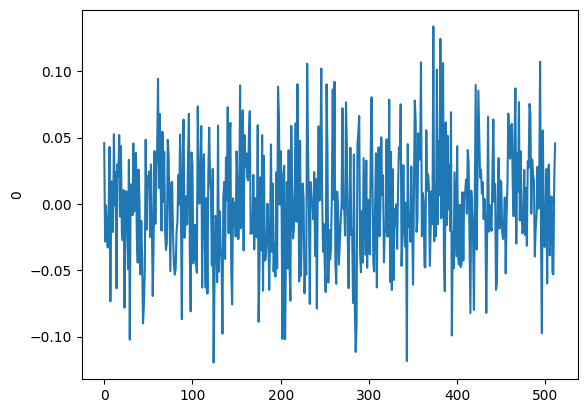

In [19]:
plt.plot(EMBEDDED_X[0])
plt.ylabel(y[0])

In [21]:
y

array([0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1])

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(EMBEDDED_X, y, shuffle=True, random_state=17)

In [24]:
from sklearn.svm import SVC

model = SVC(kernel='linear', probability=True)
model.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

In [25]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [27]:
from sklearn.metrics import accuracy_score

accuracy_score(y_train, y_pred_train)

1.0

In [28]:
accuracy_score(y_test, y_pred_test)

1.0

In [30]:
t_im = cv.imread('/content/drive/MyDrive/[02] Work/[02] Projects/[02] Facial Recognition/adarsh.jpg')
t_im = cv.cvtColor(t_im, cv.COLOR_BGR2RGB)
x, y, w, h = detector.detect_faces(t_im)[0]['box']

1/1 [==============================] - 0s 30ms/step


In [31]:
t_im = t_im[y: y + h, x: x + w]
t_im = cv.resize(t_im, (160, 160))
test_im = get_embeddings(t_im)

1/1 [==============================] - 0s 177ms/step


In [32]:
test_im = [test_im]
y_pred = model.predict(test_im)

In [33]:
y_pred

array([0])

In [34]:
encoder.inverse_transform(y_pred)

array(['adarsh'], dtype='<U13')

In [35]:
import pickle

with open('face-recognition-model.pkl', 'wb') as f:
    pickle.dump(model, f)